# Download train data and unzip convert back to torch tensor


In [1]:
!pip3 install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 5.1 MB/s eta 0:00:00


In [2]:
!gdown --id 1kGWf1Q_bi3SXzOZ822KtA6dh0CzgXvZ8

/home/arpan/miniconda3/envs/prog/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kGWf1Q_bi3SXzOZ822KtA6dh0CzgXvZ8
From (redirected): https://drive.google.com/uc?id=1kGWf1Q_bi3SXzOZ822KtA6dh0CzgXvZ8&confirm=t&uuid=71f2bd6e-72dd-47f6-aca1-a4b0a8d46432
To: /home/arpan/prog-rock/both_tensors_160_216.zip
100%|██████████████████████████████████████| 1.99G/1.99G [00:24<00:00, 82.3MB/s]


In [6]:
!unzip -j ./content/both_tensors_160_216.zip -d ./content

Archive:  ./content/both_tensors_160_216.zip
  inflating: ./content/non_progressive_rock_songs_tensor.pt  
  inflating: ./content/progressive_rock_songs_tensor.pt  


In [1]:
import torch
from torchsummary import summary

#training tensors
prog_tensors = torch.load('./content/progressive_rock_songs_tensor.pt')
non_prog_tensors = torch.load('./content/non_progressive_rock_songs_tensor.pt')

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
print(" CUDA Version is ", get_device())

 CUDA Version is  cuda:0


In [5]:
# prompt: non_prog_tensors reshaped to [8052, 160, 216])
# originally (X, 216, 160)
non_prog_tensors = non_prog_tensors.reshape(8052, 160, 216)
prog_tensors = prog_tensors.reshape(7455, 160, 216)
prog_tensors = prog_tensors.float()
non_prog_tensors = non_prog_tensors.float()

# Download validation data and mess around with it

In [13]:
# https://drive.google.com/file/d/1--QAwB8w8GVWZ1wmpPOPaj6jNkGWDI3c/view?usp=sharing
!gdown --id 1--QAwB8w8GVWZ1wmpPOPaj6jNkGWDI3c
!unzip ./content/both_tensors_160_216_validation_1.zip
import torch
prog_tensors_validation = torch.load('./content/progressive_rock_songs_validation_tensor.pt')
non_prog_tensors_validation = torch.load('./content/non_progressive_rock_songs_validation_tensor.pt')
## NOTE: the above is an array not a tensor!!

# running some ML and ensemble algorithms from sklearn


In [15]:
# prompt: i have a prog_tensors torch tensor of shape (7455, 160, 216) convert to 2d array of shape (7455, 160*216)
## Converting prog tensor to numpy array for sklearn use
import numpy as np
prog_2d_array = prog_tensors.reshape(7455, 160 * 216)
prog_2d_array = prog_2d_array.detach().numpy()

non_prog_2d_array = non_prog_tensors.reshape(8052, 160 * 216)
non_prog_2d_array = non_prog_2d_array.detach().numpy()
labels = torch.cat((torch.ones(prog_tensors.shape[0]), torch.zeros(non_prog_tensors.shape[0])), dim=0)

# Convert the labels tensor to a NumPy array
y_data = labels.detach().numpy()
X_data = np.concatenate((prog_2d_array, non_prog_2d_array), axis=0)
X_data.shape

# (15507, 34560) -> (instances, features)

(15507, 34560)

# Random forest classifier on the training data

In [16]:
from sklearn.ensemble import RandomForestClassifier
# xgboost, bagging, decision trees
model = RandomForestClassifier(n_estimators=101)
model.fit(X_data, y_data)

RandomForestClassifier(n_estimators=101)

In [17]:
print(model)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

RandomForestClassifier(n_estimators=101)
Feature ranking:
1. feature 28321 (0.000670)
2. feature 7362 (0.000650)
3. feature 7201 (0.000641)
4. feature 27361 (0.000624)
5. feature 7202 (0.000604)
6. feature 19361 (0.000553)
7. feature 28481 (0.000545)
8. feature 30241 (0.000530)
9. feature 12001 (0.000519)
10. feature 28322 (0.000487)


In [18]:
prog_true = 0
prog_false = 0
non_prog_true = 0
non_prog_false = 0
for obj in prog_tensors_validation: # obj collection of 10 sec snippets for each song in the validation set 1d array
  arr = []
  cnt = 0
  for i in obj:
    # print(i.shape)
    j = i.reshape(1, 160 * 216)
    j = j.detach().numpy()
    prediction = model.predict(j)
    # arr.append(j)
    # print(prediction[0])
    if(prediction[0] == 1.0):
      cnt = cnt+1
      # 100 snippetts
      # cnt = 60
  if(2*cnt >= len(obj)):
    prog_true+=1
  else:
    prog_false+=1

for obj in non_prog_tensors_validation:
  arr = []
  cnt = 0
  for i in obj:
    # print(i.shape)
    j = i.reshape(1, 160 * 216)
    j = j.detach().numpy()
    prediction = model.predict(j)
    # arr.append(j)
    # print(prediction[0])
    if(prediction[0] == 0):
      cnt = cnt+1
  if(2*cnt >= len(obj)):
    non_prog_true+=1
  else:
    non_prog_false+=1

print(prog_true, prog_false)
print(non_prog_false,non_prog_true)
  # prediction = model.predict([arr])
accuracy = (prog_true + non_prog_true) / (prog_true + prog_false + non_prog_true + non_prog_false)
precision = prog_true / (prog_true + prog_false)
recall = prog_true / (prog_true + non_prog_false)
print(accuracy, precision, recall)

# pretty good idk how

29 1
3 56
0.9550561797752809 0.9666666666666667 0.90625


# XGBoost

In [ ]:
# use X_data, y_data and create an XGBoost classifier
## crashed so maybe use PCA and reduce dimensions and then try classifying
import xgboost as xgb

# Create an XGBoost classifier
model_xgb = xgb.XGBClassifier()

# Train the model
model_xgb.fit(X_data, y_data)

# Print the model
print(model_xgb)


# Deep Learning starts here

In [7]:
# from sklearn.model_selection import train_test_split

# Concatenate the tensors and create labels
data = torch.cat((prog_tensors, non_prog_tensors), dim=0)
labels = torch.cat((torch.ones(prog_tensors.shape[0]), torch.zeros(non_prog_tensors.shape[0])), dim=0)

In [8]:
batch_size = 32  # Define your desired batch size
data.shape
# (instances, timesteps, features) [15507, 216, 160]

torch.Size([15507, 216, 160])

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset from your data and labels
train_dataset = TensorDataset(data, labels)
# val_dataset = TensorDataset(val_data, val_labels)
# test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoader for each dataset with the specified batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
import torch
import torch.nn as nn
# nn.Conv1d expects a batched 3-dimensional input in the shape [batch_size, in_channels, seq_length] or an unbatched 2-dimensional input in the shape [in_channels, seq_length]
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv1d(in_channels=160, out_channels=320, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(320)
        self.conv2 = nn.Conv1d(in_channels=320, out_channels=640, kernel_size=5, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(640)
        self.conv3 = nn.Conv1d(in_channels=640, out_channels=256, kernel_size=5, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm1d(128)

        # Define fully connected layers
        self.fc1 = nn.Linear(212*128, 200)  
        self.fc2 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(20, 2)

        # Define activation function
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm4(self.conv4(x)))
        x = self.dropout(x)

        # Flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Instantiate the model
model = MyConvNet()
print(model)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam optimizer with learning rate 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MyConvNet(
  (conv1): Conv1d(160, 320, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(320, 640, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm2): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(640, 256, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=27136, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [11]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [17]:
print(model)
device = get_device()
model.to(device)
model.train()
loss_hist = []
correct_predictions = 0
total_predictions = 0
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
epochs = 15

for e in range(epochs):
    i = 1
    loss_per_epoch = 0
    for inputs, labels in train_loader:
        # Perform forward pass, compute loss, and update the model
        inputs = inputs.unsqueeze(1)
        labels = labels.long()
        bs, c, time, feats = inputs.shape
        inputs = inputs.reshape(bs, time, feats)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss_per_epoch += loss.item()
        # Calculate accuracy
        # print('a',outputs.data)
        # print('b',torch.max(outputs.data, 1))
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Calculate precision
        true_positives += ((predicted == 1) & (labels == 1)).sum().item()
        false_positives += ((predicted == 1) & (labels == 0)).sum().item()
        true_negatives += ((predicted == 0) & (labels == 0)).sum().item()
        false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print metrics
        print("Epoch: {}, Batch: {}, Loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%".format(
            e, i, loss.item(), (correct_predictions / total_predictions) * 100,
            (true_positives / (true_positives + false_positives + 1e-12)) * 100  # Add small epsilon to avoid division by zero
        ))

        i += 1
    loss_hist.append(loss_per_epoch/i)
torch.save(model.state_dict(), "./model/model_conv1d_norm_3_dropout.pt")

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(model))


MyConvNet(
  (conv1): Conv1d(160, 320, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(320, 640, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm2): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(640, 256, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=27136, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (relu): ReLU()
)
Epoch: 0, Batch: 1, Loss: 0.6855, Accuracy: 54.69%, Precision: 60.61%
Epoch: 0, Batch: 2, Loss: 0.9159, Ac

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [2, 64, 216, 160]

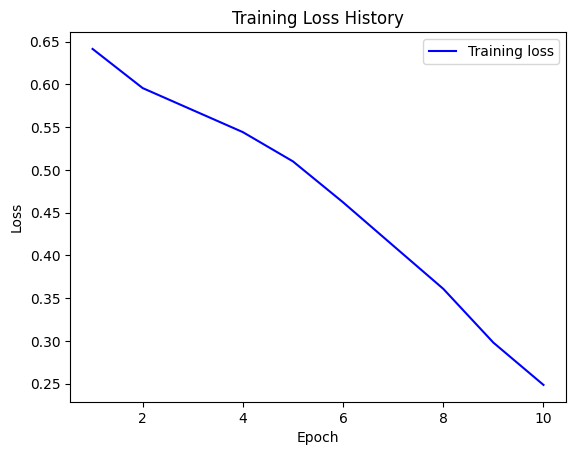

In [18]:
import matplotlib.pyplot as plt

# Create a list of epochs
epochs = range(1, len(loss_hist) + 1)

# Plot the training loss as a curve
plt.plot(epochs, loss_hist, 'b-', label='Training loss')

# Add a title and axis labels
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [1]:
print(summary(model, (160,216), 64, "cuda"))


NameError: name 'summary' is not defined

In [23]:
# https://drive.google.com/file/d/1--QAwB8w8GVWZ1wmpPOPaj6jNkGWDI3c/view?usp=sharing
# !gdown --id 1--QAwB8w8GVWZ1wmpPOPaj6jNkGWDI3c
# !unzip /content/both_tensors_160_216_validation_1.zip
import torch 
# path warning!! Colab dir are different
prog_tensors_validation = torch.load('./content/progressive_rock_songs_validation_tensor.pt')
non_prog_tensors_validation = torch.load('./content/non_progressive_rock_songs_validation_tensor.pt')
# non_prog_tensors_validation = non_prog_tensors_validation.reshape(1530, 216, 160)
# prog_tensors_validation = prog_tensors_validation.reshape(1938, 216, 160)
# prog_tensors_validation = prog_tensors_validation.float()
# non_prog_tensors_validation = non_prog_tensors_validation.float()

In [24]:
non_prog_tensors_validation[0][0].shape


torch.Size([1, 216, 160])

In [31]:
model.eval()  # Set the model to evaluation mode
## For the song
device = get_device()
model.to("cpu")
prog_true = 0
prog_false = 0
non_prog_true = 0
non_prog_false = 0
# for the individual snippets
total_prog_true = 0
total_prog_false = 0
total_non_prog_true = 0
total_non_prog_false = 0
with torch.no_grad():  # Disable gradients during validation
  correct = 0
  total = 0
  for obj in prog_tensors_validation:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      i = i.to("cpu")
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 1):
        it = it+1
    
    total_prog_true += it
    total_prog_false += (total-it)
    if(2*it >= total):
      prog_true +=1
    else:
      prog_false +=1
  for obj in non_prog_tensors_validation:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 0):
        it = it+1
    total_non_prog_true += it
    total_non_prog_false += (total-it)
    if(2*it >= total):
      non_prog_true +=1
    else:
      non_prog_false +=1


print(prog_true, prog_false)
print(non_prog_false, non_prog_true)

print(total_prog_true, total_prog_false)
print(total_non_prog_false, total_non_prog_true)
# with torch.no_grad():  # Disable gradients during validation
#   correct = 0
#   total = 0
#   for inputs, labels in val_loader:
#     inputs.shape
#     outputs = model(inputs)
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     print('label',labels)
#     print('predicted',predicted)
#     correct += (predicted == labels).sum().item()
#     print(correct / total)
#   val_accuracy = correct / total
#   print(f"Validation accuracy: {val_accuracy:.4f}")

28 2
2 57
1739 199
206 1324


# Testing

In [2]:
import torch 
# path warning!! Colab dir are different
prog_tensors_validation = torch.load('./test-tensors/progressive_rock_songs_test_tensor.pt')
non_prog_tensors_validation = torch.load('./test-tensors/non_progressive_rock_songs_test_tensor.pt')

In [5]:
# model/model_conv1d_norm_1_large.pt
model_path = "./model/model_conv1d_norm_1_large.pt"
model_state_dict = torch.load(model_path)
# Print model details
print("Model state dictionary keys:")
for key in model_state_dict.keys():
    print(key)
print("\nModel layer details:")
for key, value in model_state_dict.items():
    print(f"Layer: {key}")
    print(f" Shape: {value.shape}")
    print(f" Data type: {value.dtype}")
    print(f" Device: {value.device}")
print()

Model state dictionary keys:
conv1.weight
conv1.bias
batchnorm1.weight
batchnorm1.bias
batchnorm1.running_mean
batchnorm1.running_var
batchnorm1.num_batches_tracked
conv2.weight
conv2.bias
batchnorm2.weight
batchnorm2.bias
batchnorm2.running_mean
batchnorm2.running_var
batchnorm2.num_batches_tracked
conv3.weight
conv3.bias
batchnorm3.weight
batchnorm3.bias
batchnorm3.running_mean
batchnorm3.running_var
batchnorm3.num_batches_tracked
conv4.weight
conv4.bias
batchnorm4.weight
batchnorm4.bias
batchnorm4.running_mean
batchnorm4.running_var
batchnorm4.num_batches_tracked
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias

Model layer details:
Layer: conv1.weight
 Shape: torch.Size([320, 160, 3])
 Data type: torch.float32
 Device: cpu
Layer: conv1.bias
 Shape: torch.Size([320])
 Data type: torch.float32
 Device: cpu
Layer: batchnorm1.weight
 Shape: torch.Size([320])
 Data type: torch.float32
 Device: cpu
Layer: batchnorm1.bias
 Shape: torch.Size([320])
 Data type: torch.float32
 Dev

In [6]:
model = model_state_dict
model.eval()  # Set the model to evaluation mode
## For the song
# device = get_device()
# model.to("cpu")
prog_true = 0
prog_false = 0
non_prog_true = 0
non_prog_false = 0
# for the individual snippets
total_prog_true = 0
total_prog_false = 0
total_non_prog_true = 0
total_non_prog_false = 0
with torch.no_grad():  # Disable gradients during validation
  correct = 0
  total = 0
  for obj in prog_tensors_validation:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      i = i.to("cpu")
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 1):
        it = it+1
    
    total_prog_true += it
    total_prog_false += (total-it)
    if(2*it >= total):
      prog_true +=1
    else:
      prog_false +=1
  for obj in non_prog_tensors_validation:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 0):
        it = it+1
    total_non_prog_true += it
    total_non_prog_false += (total-it)
    if(2*it >= total):
      non_prog_true +=1
    else:
      non_prog_false +=1


print(prog_true, prog_false)
print(non_prog_false, non_prog_true)

print(total_prog_true, total_prog_false)
print(total_non_prog_false, total_non_prog_true)
# with torch.no_grad():  # Disable gradients during validation
#   correct = 0
#   total = 0
#   for inputs, labels in val_loader:
#     inputs.shape
#     outputs = model(inputs)
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     print('label',labels)
#     print('predicted',predicted)
#     correct += (predicted == labels).sum().item()
#     print(correct / total)
#   val_accuracy = correct / total
#   print(f"Validation accuracy: {val_accuracy:.4f}")

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'